In [1]:
import pandas as pd
import numpy as np
import os,sys
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
#Parameters
window_size = 12

# Understanding the data

In [3]:
csv_path = '/Users/mongchanghsi/Desktop/SUTD/Term 7/01.116/Healthcare_AI_Assignment_2/HDeviceCGM.csv'
excel_data = pd.read_csv(csv_path) # Already in DataFrame format

col_to_remove = ['ParentHDeviceUploadsID', 'PtID', 'SiteID', 'DeviceTm', 'DexInternalDtTmDaysFromEnroll', 'DexInternalTm', 'RecordType']
cleansed_excel_data = excel_data.drop(columns=col_to_remove)

print(cleansed_excel_data)

         RecID  DeviceDtTmDaysFromEnroll  GlucoseValue
0     15047224                         6            76
1     15047225                         6            75
2     15047226                         6            74
3     15047227                         6            72
4     15047228                         6            71
...        ...                       ...           ...
2957  15047643                         6           142
2958  15047644                         5           146
2959  15047645                         5           150
2960  15047646                         5           154
2961  15047647                         5           159

[2962 rows x 3 columns]


Checkpoint1:Study the training data-set and answer the following 
    1) How many sets of continuous training data sets do you have available 
    2) Thecount of samples points per training data sets. Segments the data-sets into training and testing.

In [4]:
set_counter = []
for i in range(len(cleansed_excel_data)):
    index = cleansed_excel_data.iloc[i].DeviceDtTmDaysFromEnroll
    if index not in set_counter:
        set_counter.append(index)
print(f'There are total of {len(set_counter)} number of continuous dataset.')

for i in range(0,11):
    continuous_set = cleansed_excel_data[cleansed_excel_data.DeviceDtTmDaysFromEnroll==i]
    print("Set ",i," with ", len(continuous_set), " data points")

There are total of 11 number of continuous dataset.
Set  0  with  101  data points
Set  1  with  292  data points
Set  2  with  290  data points
Set  3  with  291  data points
Set  4  with  294  data points
Set  5  with  297  data points
Set  6  with  290  data points
Set  7  with  231  data points
Set  8  with  292  data points
Set  9  with  291  data points
Set  10  with  293  data points


In [5]:
# Initialize the main training and testing dataset using first index of continuous dataset
continuous_set = cleansed_excel_data[cleansed_excel_data.DeviceDtTmDaysFromEnroll==0]
train, test = train_test_split(continuous_set,train_size = 0.8, shuffle = False)

# Append the rest of the training and testing of the continuous dataset into the main training and testing dataset
for i in range(1,11):
    continuous_set = cleansed_excel_data[cleansed_excel_data.DeviceDtTmDaysFromEnroll==i]
    
    # Shuffle is set to False to preserve the time series sequence
    # _train and _test are the training and testing set of the individual continuous dataset
    _train, _test = train_test_split(continuous_set, train_size = 0.8, shuffle = False)

    # Thereafter, append the _train and _test into the main training and test dataset
    train = train.append(_train, ignore_index=True)
    test = test.append(_test,ignore_index=True)

# Data Pre-Processing

Checkpoint 2: Display the dimensions for your pre-processed data and explain how it the window size is incorporated into this structure.

In [6]:
# Utility function to convert time series data to sequences
def split_sequences(features, labels, steps):
    X, y = [], []
    features = np.array(features).reshape(-1,1)
    labels = np.array(labels).reshape(-1,1)
    for i in range(len(features) - 1):
        # Find the end of this specific sequence
        end_ix = i + steps
        # Check if the end of this specific sequence is outside of the dataset
        if end_ix > len(features) - 1:
            break
        # Split the sequence into train x and test y
        seq_x, seq_y = features[i:end_ix, :], labels[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
train_X, train_y = [], []
test_X, test_y = [], []

# To generate training and testing data sequences
for i in range(0,11):
    # Generate sequences of training data
    continuous_values = train.GlucoseValue[train.DeviceDtTmDaysFromEnroll==i]
    inputs, outputs = split_sequences(continuous_values, continuous_values, window_size)
    train_X.extend(inputs)
    train_y.extend(outputs)
    
    # Generate sequences of testing data
    continuous_values = test.GlucoseValue[test.DeviceDtTmDaysFromEnroll==i]
    inputs, outputs = split_sequences(continuous_values, continuous_values, window_size)
    test_X.extend(inputs)
    test_y.extend(outputs)
    
# Convert to numpy arrays
train_X, train_y = np.array(train_X), np.array(train_y)
test_X, test_y = np.array(test_X), np.array(test_y)

In [8]:
print("Shape of traning Input: ", train_X.shape)
print("Shape of testing Input: ", test_X.shape)
print("Shape of traning Output: ", train_y.shape)
print("Shape of testing Output: ", test_y.shape)

Shape of traning Input:  (2232, 12, 1)
Shape of testing Input:  (466, 12, 1)
Shape of traning Output:  (2232, 1)
Shape of testing Output:  (466, 1)


The window size is used to define on how much previous values of time we want to use for prediction. For example if we take window size = 5 then sequences are genereated such that for T-4,T-3,T-2,T-1,T input, the output is T+1.

Checkpoint 3: Explain how this many-to-one structure is presented is incorporated in your data structure.

The input is converted into sequence of inputs. The size of sequence is equal to window size.
After converting to sequences of inputs of length window size, now there are multiple inputs and one output in each training example.

Let PROCESSED_DATASET_SIZE be the total number of sequences generated after processing them the preprocessing function where it splits into the window_size.

In case of window size 5, there are 5 inputs (T-4, T-3, T-2, T-1, T) and one output (T+1).
The model take input of shape (PROCESSED_DATASET_SIZE , window_size, no of features). In our case no of features is 1 since we are only predicting the GlucoseValue. The output for this sequence of inputs is 1 value or of shape (PROCESSED_DATASET_SIZE, 1)

# Modelling And training

Checkpoint 4: Select the correct Loss Function and optimiser and explain the reason for your choice

In [9]:
model_input = tf.keras.Input(shape=(window_size, 1), name = 'input')
x = tf.keras.layers.LSTM(32, activation='relu')(model_input)
model_output = tf.keras.layers.Dense(1, activation = 'linear', name = 'output')(x)

model = tf.keras.Model(inputs=[model_input], outputs=[model_output])

model.compile(optimizer='adam', loss='mae', metrics= [tf.keras.metrics.RootMeanSquaredError()]) 

Selection of Optimizer: Adaptive Moment Estimation (ADAM) optimizer uses adaptive learning rate. It computes individual adaptive learning rates for different parameters.  

Selection of Loss Function: For this model, I have selected the mean absolute error as the loss function. As it is a regression problem, the error is absolute of difference between actual and predicted values.

In [10]:
# training the model with 20% validation data
history = model.fit(train_X, train_y, validation_split= 0.2, shuffle=True, epochs=100, batch_size=16)

Epoch 1/100
112/112 [==============================] - 2s 8ms/step - loss: 93.4698 - root_mean_squared_error: 111.7991 - val_loss: 23.2915 - val_root_mean_squared_error: 44.3397
Epoch 2/100
112/112 [==============================] - 0s 3ms/step - loss: 19.0397 - root_mean_squared_error: 34.3575 - val_loss: 17.3995 - val_root_mean_squared_error: 34.7947
Epoch 3/100
112/112 [==============================] - 0s 3ms/step - loss: 12.6296 - root_mean_squared_error: 23.7357 - val_loss: 13.1956 - val_root_mean_squared_error: 32.2011
Epoch 4/100
112/112 [==============================] - 0s 3ms/step - loss: 9.8218 - root_mean_squared_error: 20.3907 - val_loss: 13.3773 - val_root_mean_squared_error: 31.8032
Epoch 5/100
112/112 [==============================] - 0s 3ms/step - loss: 10.9326 - root_mean_squared_error: 22.9776 - val_loss: 11.6867 - val_root_mean_squared_error: 30.7317
Epoch 6/100
112/112 [==============================] - 0s 3ms/step - loss: 8.0638 - root_mean_squared_error: 18.018

112/112 [==============================] - 0s 3ms/step - loss: 4.6420 - root_mean_squared_error: 12.2214 - val_loss: 6.8216 - val_root_mean_squared_error: 24.7672
Epoch 48/100
112/112 [==============================] - 0s 3ms/step - loss: 5.0766 - root_mean_squared_error: 14.6097 - val_loss: 6.9825 - val_root_mean_squared_error: 24.9552
Epoch 49/100
112/112 [==============================] - 0s 3ms/step - loss: 4.8284 - root_mean_squared_error: 14.4457 - val_loss: 7.4390 - val_root_mean_squared_error: 24.9536
Epoch 50/100
112/112 [==============================] - 0s 3ms/step - loss: 5.3565 - root_mean_squared_error: 16.6091 - val_loss: 7.7944 - val_root_mean_squared_error: 27.9912
Epoch 51/100
112/112 [==============================] - 0s 3ms/step - loss: 5.2255 - root_mean_squared_error: 14.9265 - val_loss: 6.7148 - val_root_mean_squared_error: 25.1746
Epoch 52/100
112/112 [==============================] - 0s 3ms/step - loss: 3.8282 - root_mean_squared_error: 11.4353 - val_loss: 6.7

112/112 [==============================] - 0s 4ms/step - loss: 5.3385 - root_mean_squared_error: 16.2565 - val_loss: 7.3621 - val_root_mean_squared_error: 27.5804
Epoch 94/100
112/112 [==============================] - 0s 3ms/step - loss: 5.8408 - root_mean_squared_error: 19.4694 - val_loss: 7.8561 - val_root_mean_squared_error: 28.7002
Epoch 95/100
112/112 [==============================] - 0s 4ms/step - loss: 5.0861 - root_mean_squared_error: 16.5230 - val_loss: 7.6450 - val_root_mean_squared_error: 26.9396
Epoch 96/100
112/112 [==============================] - 0s 4ms/step - loss: 4.9495 - root_mean_squared_error: 16.4627 - val_loss: 7.1200 - val_root_mean_squared_error: 27.8485
Epoch 97/100
112/112 [==============================] - 1s 6ms/step - loss: 4.4960 - root_mean_squared_error: 14.5821 - val_loss: 7.5909 - val_root_mean_squared_error: 28.1734
Epoch 98/100
112/112 [==============================] - 0s 4ms/step - loss: 5.3486 - root_mean_squared_error: 19.1492 - val_loss: 6.8

Checkpoint 5: Graph and display the training loss of the model.

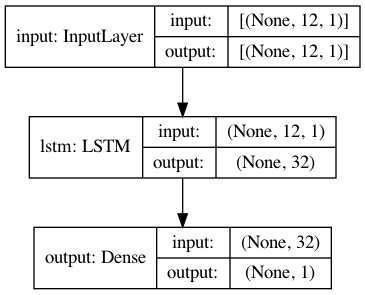

In [11]:
dot_img_file = '/Users/mongchanghsi/Desktop/SUTD/Term 7/01.116/Healthcare_AI_Assignment_2/model/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, expand_nested=True,show_shapes=True)

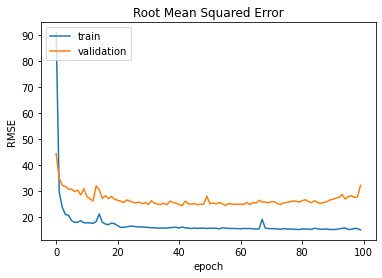

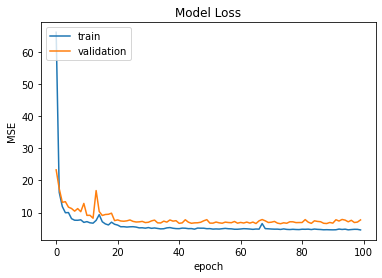

In [12]:
# plotting the training/validation loss
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Root Mean Squared Error')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Validation

Checkpoint 6: Graph the remaining instances and plot them (Provide the
true data and the validated data on the same graph), display the mean loss for
each of the instance.

In [13]:
pred = model.predict(test_X)

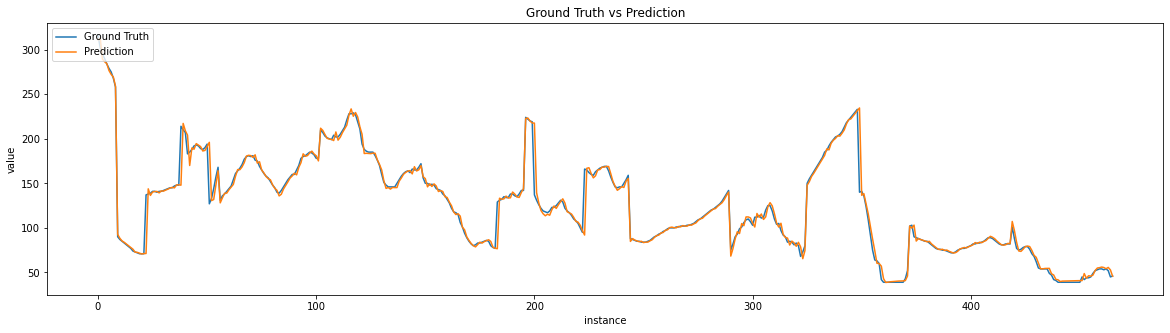

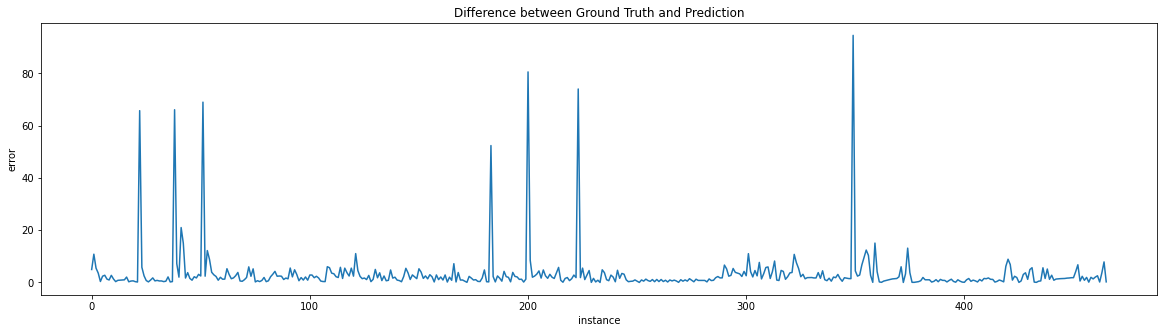

In [14]:
#plotting the ground truth vs prediction for each instance
plt.figure(figsize=(20,5))
plt.plot(test_y)
plt.plot(pred)
plt.title('Ground Truth vs Prediction')
plt.ylabel('value')
plt.xlabel('instance')
plt.legend(['Ground Truth', 'Prediction'], loc='upper left')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(abs(test_y-pred))
plt.title('Difference between Ground Truth and Prediction')
plt.ylabel('error')
plt.xlabel('instance')
plt.show()

# Optimisation

Checkpoint 7: Write a short report presenting your analysis on the optimal hyper-parameter of choice. You may include the necessary graphs or printout to explain your optimal hyper-parameter of choice.

The learning rate is used default learning rate of adam optimizer and other regularization parameters are default values.
The loss function is mean absolute error and evalation metric is root mean squared error. As it is regression problem of predicting the value of glucose level based on previous values.  
The only parameters needed to tune were number of layers and window size.

We will perform some permutations on the number of LSTM layers and the window size to determine the best hyperparamters for this problem.

For layer = 1, window_size = 5: loss = 5.3657

For layer = 1, window_size = 12: loss = 4.3209

For layer = 1, window_size = 24: loss = 6.3971

For layer = 3, window_size = 5: loss = 5.2859

For layer = 3, window_size = 12: loss = 5.0005

For layer = 3, window_size = 24: loss = 34.0367


From the information that I have gathered, hence the reason why the model has layer = 1 and a window_size = 12.

For the test of the 3 layers, I have used the following model

model_input = tf.keras.Input(shape=(window_size, 1), name = 'input')

x = tf.keras.layers.LSTM(32,activation='relu', return_sequences=True)(model_input)

x = tf.keras.layers.LSTM(32, return_sequences=True)(x)

x = tf.keras.layers.LSTM(32, activation='relu')(x)

x = tf.keras.layers.Dense(512, activation = 'linear')(x)

model_output = tf.keras.layers.Dense(1, activation = 'linear', name = 'output')(x)
